<a href="https://colab.research.google.com/github/scottthomaswx/RadarHodographs/blob/main/RadarHodograph_MostRecent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Needed Packages

In [ ]:
# @title
%%capture
!pip install matplotlib
!pip install numpy
!pip install arm-pyart
!pip install metpy
!pip install pint
!pip install math
!pip install os
!pip install pandas
!pip install warnings
!pip install datetime
!pip install siphon
!pip install nexradaws
!pip install requests
!pip install glob

import matplotlib.pyplot as plt
from metpy.units import units
import pyart
import numpy as np
from metpy.plots import Hodograph
import metpy.calc as mpcalc
import matplotlib.colors as colors
from pint import UnitRegistry
import math
import os
import pandas as pd
import warnings
from datetime import datetime, timedelta
import tempfile
import nexradaws
import requests
import glob

!rm -rf sample_data
!mkdir hodos
!mkdir sr_hodos

#Give Needed Information

In [ ]:
radar_id = 'KHTX' #Make Uppercase
data_ceiling = 10000 #Max Data Height in meters AGL

#Pull Data

In [ ]:
# @title
# start connection
conn = nexradaws.NexradAwsInterface()

# get the time and an earlier time
rightnow = datetime.utcnow()
yesterdate = rightnow - timedelta(days = 1)
year = rightnow.strftime('%Y')
month = rightnow.strftime('%m')
day = rightnow.strftime('%d')
yesteryear = yesterdate.strftime('%Y')
yestermonth = yesterdate.strftime('%m')
yesterday = yesterdate.strftime('%d')


# query the scans
try:
  availscans = conn.get_avail_scans(year, month, day, radar_id)
except:
  availscans = conn.get_avail_scans(yesteryear, yestermonth, yesterday, radar_id)

templocation = tempfile.TemporaryDirectory(dir=os.getcwd())
results = conn.download(availscans[-1], templocation.name)
dir = templocation.name
for a in os.listdir(dir):
  file = a
  if glob.glob(templocation.name +'/*MDM*' ):
    os.remove(templocation.name +'/' + file)
    results = conn.download(availscans[-2], templocation.name)
    for a in os.listdir(dir):
      file = a

Downloaded KHTX20241229_023043_V06
1 out of 1 files downloaded...0 errors


#Get Needed Strings and Create VWP

In [ ]:
# @title
rad = file.split('/')[3]
time = rad.split('_')[1]
seg = rad.split('_')[0]
date = seg[4:]

n = 2

out = []
for i in range(0, len(time), n):
    out.append(time[i:i+n])

datearr = []
for i in range(0, len(date), n):
    datearr.append(date[i:i+n])

radar = pyart.io.read(file)

# create a gate filter which specifies gates to exclude from dealiasing
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_transition()
gatefilter.exclude_invalid("velocity")
gatefilter.exclude_invalid("reflectivity")
gatefilter.exclude_outside("reflectivity", 0, 80)

# perform dealiasing
dealias_data = pyart.correct.dealias_region_based(radar, gatefilter=gatefilter)
radar.add_field("corrected_velocity", dealias_data)

# Loop on all sweeps and compute VAD
zlevels = np.arange(100, data_ceiling+100, 100)  # height above radar
u_allsweeps = []
v_allsweeps = []

for idx in range(radar.nsweeps):
  radar_1sweep = radar.extract_sweeps([idx])
  try:
    vad = pyart.retrieve.vad_browning(radar_1sweep, "corrected_velocity", z_want=zlevels)
    u_allsweeps.append(vad.u_wind)
    v_allsweeps.append(vad.v_wind)
  except ValueError:
      pass

# Average U and V over all sweeps and compute magnitude and angle
u_avg = np.nanmean(np.array(u_allsweeps), axis=0)
v_avg = np.nanmean(np.array(v_allsweeps), axis=0)
orientation = np.rad2deg(np.arctan2(-u_avg, -v_avg)) % 360
speed = np.sqrt(u_avg**2 + v_avg**2)
u_avg *= 1.944
v_avg *= 1.944

#Max Height Check
##Read Output To Check Restrictions on Storm Motion

In [ ]:
# @title
maxhgtidx = len(u_avg) - sum(np.isnan(u_avg))
maxhgt = zlevels[maxhgtidx -1]
if maxhgt < 6000:
  warnings.warn("\n \033[1mWARNING:\033[0m \n Max wind height is under 6000m AGL \n Must use User Selected Storm Motion to get Storm Relative Hodograph or SRH/SWV")
else:
  print("Max wind height is greater than 6000m AGL: Use Any Storm Motion")

Max wind height is greater than 6000m AGL: Use Any Storm Motion


#Get Storm Motion and Plot Info

In [ ]:
#Storm Motion
storm_motion_method = 'Bunkers Right' #Choose Mean Wind, Bunkers Left, Bunkers Right, User Selected, Corfidi Downshear, Corfidi Upshear

#Enter User Selected Storm Motion
sm_dir = 250
sm_speed = 35

#Surface Winds
sfc_status = 'Preset' #Enter Preset, ASOS_ID, Manual, or None

#Plot Info

range_type = 'Static' #Enter Dynamic For Changing Range From Values or Static for Constant Range Value
static_value = 70 # Enter Static Hodo Range or 999 To Not Use

#Pull Surface Winds

In [ ]:
# @title
API_TOKEN = '86eac26a58a647e69b8c69feaef76bae'
API_ROOT = "https://api.synopticdata.com/v2/"

def mesowest_get_sfcwind(api_args):
    """
    For each station in a list of stations, retrieves all observational data
    within a defined time range using mesowest API. Writes the retrieved data
    and associated observation times to a destination file. API documentation:

        https://api.synopticdata.com/v2/stations/nearesttime

    Parameters
    ----------
      api_args  : dictionary


    Returns
    -------
        jas_ts  : json file
                dictionary of all observations for a given station.
                What is most significant, however, is writing the
                observed data to a file that then can be manipulated
                for plotting.

    """
    station = api_args["stid"]
    api_request_url = os.path.join(API_ROOT, "stations/nearesttime")
    req = requests.get(api_request_url, params=api_args)
    jas_ts = req.json()
    for s in range(0,len(jas_ts['STATION'])):
        try:
            station = jas_ts['STATION'][s]
            stn_id = station['STID']
            ob_times = station['OBSERVATIONS']['wind_speed_value_1']['date_time']
            wnspd = station['OBSERVATIONS']['wind_speed_value_1']['value']
            wndir = station['OBSERVATIONS']['wind_direction_value_1']['value']
        except:
            pass
    return wnspd, wndir
if sfc_status == 'ASOS_ID':
  api_args = {"token":API_TOKEN, "stid": f"{nearest_asos}", "attime": f"{date}{out[0]}{out[1]}", "within": 60,"status":"active", "units":"speed|kts",  "hfmetars":'1'}
  wnspd, wndir = mesowest_get_sfcwind(api_args)
  sfc_dir = wndir
  sfc_spd = wnspd

if sfc_status == 'Preset':
  radar_list = pd.read_csv('https://raw.githubusercontent.com/scottthomaswx/RadarHodographs/main/RadarInfo.csv')
  track = np.where(radar_list['Site ID'] == radar_id)
  nearest_asos = radar_list['Primary ASOS'][track[0]].item()
  api_args = {"token":API_TOKEN, "stid": f"{nearest_asos}", "attime": f"{date}{out[0]}{out[1]}", "within": 60,"status":"active", "units":"speed|kts",  "hfmetars":'1'}
  wnspd, wndir = mesowest_get_sfcwind(api_args)
  if wndir == ''or wnspd  == '':
    nearest_asos = radar_list['Secondary ASOS'][track[0]].item()
    newapi_args = {"token":API_TOKEN, "stid": f"{nearest_asos}", "attime": f"{date}{out[0]}{out[1]}", "within": 60,"status":"active", "units":"speed|kts",  "hfmetars":'1'}
    wnspd, wndir = mesowest_get_sfcwind(newapi_args)
  sfc_dir = wndir
  sfc_spd = wnspd

#Calculate Storm Motion and Parameters



In [ ]:
# @title
def calc_components(speed, direction):
  u_comp = speed * np.cos(np.deg2rad(direction))
  v_comp = speed * np.sin(np.deg2rad(direction))
  return u_comp, v_comp

def calc_vector(u_comp, v_comp):
  mag = np.sqrt(u_comp**2 + v_comp**2)
  dir = np.rad2deg(np.arctan2(u_comp, v_comp)) % 360
  return mag, dir

def calc_shear(u_layer, v_layer, height, zlevels):
  layer_top = np.where(zlevels == (height*1000))[0][0]
  u_shr = u_layer[layer_top] - u_layer[0]
  v_shr = v_layer[layer_top] - v_layer[0]
  shrmag = np.hypot(u_shr, v_shr)
  return shrmag

def calc_meanwind(u_layer, v_layer, zlevels, layertop):
  layer_top = np.where(zlevels == (layertop))[0][0]
  mean_u = np.mean(u_layer[:layer_top])
  mean_v = np.mean(v_layer[:layer_top])
  return mean_u, mean_v

def calc_bunkers(u_layer, v_layer, zlevels):
  layer_top = np.where(zlevels == (6000))[0][0]
  mean_u = np.mean(u_layer[:layer_top])
  mean_v = np.mean(v_layer[:layer_top])

  layer_top = np.where(zlevels == (6000))[0][0]
  u_shr = u_layer[layer_top] - u_layer[0]
  v_shr = v_layer[layer_top] - v_layer[0]

  dev = 7.5 * 1.94

  dev_amnt = dev / np.hypot(u_shr, v_shr)
  rstu = mean_u + (dev_amnt * v_shr)
  rstv = mean_v - (dev_amnt * u_shr)
  lstu = mean_u - (dev_amnt * v_shr)
  lstv = mean_v + (dev_amnt * u_shr)
  rmag, rdir = calc_vector(rstu, rstv)
  lmag, ldir = calc_vector(lstu, lstv)

  return rstu, rstv, lstu, lstv, rmag, rdir, lmag, ldir

def calc_corfidi(u_layer, v_layer, zlevels, u_mean, v_mean):
  llj_top = np.where(zlevels == (1500))[0][0]
  llj_u = u_layer[:llj_top]
  llj_v = v_layer[:llj_top]

  mag, dir = calc_vector(llj_u, llj_v)
  max=0
  i=0
  for a in mag:
    if mag[i] >= mag[i-1]:
      max = i

  u_max = llj_u[i]
  v_max = llj_v[i]

  corfidi_up_u = u_mean - u_max
  corfidi_up_v =  v_mean - v_max

  corfidi_down_u = u_mean + corfidi_up_u
  corfidi_down_v = v_mean + corfidi_up_v

  return corfidi_up_u, corfidi_up_v, corfidi_down_u, corfidi_down_v

def conv_angle_param(ang):
  ang = ang+180
  if ang < 0:
    ang += 360
  if ang > 360:
    ang -= 360
  return ang

def conv_angle_enter(ang):
  ang = 270 - ang
  if ang < 0:
    ang += 360
  if ang > 360:
    ang -= 360
  return ang

def calc_dtm(u_300, v_300, rmu, rmv):
  dtm_u = rmu + u_300 /2
  dtm_v = rmv + v_300 /2
  return dtm_u, dtm_v

def calculate_sr_wind(u_wind, v_wind):
    try:
      sr_u = u_avg - u_wind
      sr_v = v_avg - v_wind
      sr_mw_u = u_mean - u_wind
      sr_br_u = rmu - u_wind
      sr_bl_u = lmu - u_wind
      sr_mw_v = v_mean - v_wind
      sr_br_v = rmv - v_wind
      sr_bl_v = lmv - v_wind
      sr_sfc_u = sfc_u - u_wind
      sr_sfc_v = sfc_v - v_wind
      sr_cu_u =  cvu_u - u_wind
      sr_cd_u = cvd_u - u_wind
      sr_cu_v = cvu_v - v_wind
      sr_cd_v = cvd_v - v_wind
      sr_dtm_u = dtm_u - u_wind
      sr_dtm_v = dtm_v - v_wind
      sr_sm_u = u_sm - u_wind
      sr_sm_v = v_sm - v_wind
      return sr_u, sr_v, sr_mw_u, sr_br_u, sr_bl_u, sr_mw_v, sr_br_v, sr_bl_v, sr_sfc_u, sr_sfc_v, sr_cu_u, sr_cd_u, sr_cd_v, sr_cu_v, sr_dtm_u, sr_dtm_v, sr_sm_u, sr_sm_v
    except:
      warnings.warn('ERROR: Data Missing For Storm Relative calculations with this method: For data missing under 6000m AGL User Selected Storm Motion Required')

#Calculate Bulk Shear
if data_ceiling >= 500:
  shr005 = calc_shear(u_avg, v_avg, 0.5, zlevels)
  if np.isnan(shr005) == True:
    shr005 = '--'
  else:
    shr005 = round(shr005)
else:
  shr005 = '--'

if data_ceiling >= 1000:
  shr01 = calc_shear(u_avg, v_avg, 1, zlevels)
  if np.isnan(shr01):
    shr01= '--'
  else:
    shr01 = round(shr01)
else:
  shr01 = '--'

if data_ceiling >= 3000:
  shr03 = calc_shear(u_avg, v_avg, 3, zlevels)
  if np.isnan(shr03):
    shr03 = '--'
  else:
    shr03 = round(shr03)
else:
  shr03 = '--'

if data_ceiling >= 6000:
  shr06 = calc_shear(u_avg, v_avg, 6, zlevels)
  if np.isnan(shr06):
    shr06 = '--'
  else:
    shr06 = round(shr06)
else:
  shr06 = '--'

if data_ceiling >= 8000:
  shr08 = calc_shear(u_avg, v_avg, 8, zlevels)
  if np.isnan(shr08):
    shr08 = '--'
  else:
    shr08 = round(shr08)
else:
  shr08 = '--'

#Calculate Storm Motions
if data_ceiling >= 6000:
  u_mean, v_mean = calc_meanwind(u_avg, v_avg, zlevels, 6000)
  mean_mag, mean_dir = calc_vector(u_mean, v_mean)
  if np.isnan(mean_mag) == False:
    mean_mag = round(mean_mag)
  if np.isnan(mean_mag):
    mean_mag = '--'
  rmu, rmv, lmu, lmv, rmag, rdir, lmag, ldir = calc_bunkers(u_avg, v_avg, zlevels)
  if np.isnan(rmag) == False:
    rmag = round(rmag)
  if np.isnan == False:
    rmag = '--'
  if np.isnan(lmag) == False:
    lmag = round(lmag)
  if np.isnan(lmag):
    lmag = '--'
  cvu_u, cvu_v, cvd_u, cvd_v = calc_corfidi(u_avg, v_avg, zlevels, u_mean, v_mean)
  cor_u_mag, cor_u_dir = calc_vector(cvu_u, cvu_v)
  if np.isnan(cor_u_mag) == False:
    cor_u_mag = round(cor_u_mag)
  if np.isnan(cor_u_mag):
    cor_u_mag = '--'
  cor_d_mag, cor_d_dir = calc_vector(cvd_u, cvd_v)
  if np.isnan(cor_d_mag) == False:
   cor_d_mag =  round(cor_d_mag)
  if np.isnan(cor_d_mag):
    cor_d_mag = '--'
else:
  mean_mag = '--'
  mean_dir = '---'
  rmu = np.nan
  rmv = np.nan
  lmu = np.nan
  lmv = np.nan
  rmag = '--'
  rdir = '---'
  lmag = '--'
  ldir = '---'
  cor_u_mag = '--'
  cor_u_dir = '---'
  cor_d_mag = '--'
  cor_d_dir = '---'
  u_mean = np.nan
  v_mean = np.nan
  rmu = np.nan
  rmv = np.nan
  lmu = np.nan
  lmv = np.nan
  cvu_u = np.nan
  cvu_v = np.nan
  cvd_u = np.nan
  cvd_v = np.nan

#Calculate Deviant Tornado Motion
if data_ceiling >= 6000:
  u_300, v_300 = calc_meanwind(u_avg, v_avg, zlevels, 300)
  dtm_u, dtm_v = calc_dtm(u_300, v_300, rmu, rmv)
  dtm_mag, dtm_dir = calc_vector(dtm_u, dtm_v)
  if np.isnan(dtm_mag) == False:
   dtm_mag =  round(dtm_mag)
else:
  dtm_mag, dtm_dir = '--'
  dtm_u = np.nan
  dtm_v = np.nan

#Calculate meteorological angles
try:
  sfc_angle = conv_angle_enter(sfc_dir)
except:
  sfc_angle = '---'
try:
  us_ang_cor = conv_angle_enter(sm_dir)
except:
  us_ang_cor = '---'
try:
  mean_dirmet = conv_angle_param(mean_dir)
  if np.isnan(mean_dirmet) == False:
    mean_dirmet = round(mean_dirmet)
  if np.isnan(mean_dirmet):
    mean_dirmet = '---'
except:
  mean_dirmet = '---'
try:
  rang = conv_angle_param(rdir)
  if np.isnan(rang) == False:
   rang =  round(rang)
  if np.isnan(rang):
   rang =  '---'
except:
  rang = '---'
try:
  lang = conv_angle_param(ldir)
  if np.isnan(lang) == False:
   lang = round(lang)
  if np.isnan(lang):
   lang = '---'
except:
  lang = '---'
try:
  down_adj = conv_angle_param(cor_d_dir)
  if np.isnan(down_adj) == False:
    down_adj = round(down_adj)
  if np.isnan(down_adj):
    down_adj = '---'
except:
  down_adj = '---'
try:
  up_adj = conv_angle_param(cor_u_dir)
  if np.isnan(up_adj) == False:
   up_adj = round(up_adj)
  if np.isnan(up_adj):
   up_adj = '---'
except:
  up_adj = '---'
try:
  dtm_dir_cor = conv_angle_param(dtm_dir)
  if np.isnan(dtm_dir_cor) == False:
    dtm_dir_cor = round(dtm_dir_cor)
  if np.isnan(dtm_dir_cor):
    dtm_dir_cor = '---'
except:
  dtm_dir_cor = '---'


#Calculate Sfc Wind Components
if sfc_dir != 'None':
  try:
    sfc_angle = conv_angle_enter(sfc_dir)
  except:
    sfc_angle = '---'
  sfc_u, sfc_v = calc_components(sfc_spd, sfc_angle)
  if np.isnan(sfc_angle) == False:
    sfc_angle = round(sfc_angle)
  if np.isnan(sfc_angle):
    sfc_angle = '---'

  #Calculate User Selected Motion Components
  try:
    us_ang_cor = conv_angle_enter(sm_dir)
  except:
    us_ang_cor = '---'
  u_sm, v_sm = calc_components(sm_speed, us_ang_cor)
  if np.isnan(us_ang_cor) == False:
    us_ang_cor = round(us_ang_cor)
  if np.isnan(us_ang_cor):
    us_ang_cor = '---'

#Create Storm Relative Flow Based On Selected Data
if storm_motion_method == 'Mean Wind':
  sr_u, sr_v, sr_mw_u, sr_br_u, sr_bl_u, sr_mw_v, sr_br_v, sr_bl_v, sr_sfc_u, sr_sfc_v, sr_cu_u, sr_cd_u, sr_cd_v, sr_cu_v, sr_dtm_u, sr_dtm_v, sr_sm_u, sr_sm_v = calculate_sr_wind(u_mean, v_mean)

if storm_motion_method == 'User Selected':
  sr_u, sr_v, sr_mw_u, sr_br_u, sr_bl_u, sr_mw_v, sr_br_v, sr_bl_v, sr_sfc_u, sr_sfc_v, sr_cu_u, sr_cd_u, sr_cd_v, sr_cu_v, sr_dtm_u, sr_dtm_v, sr_sm_u, sr_sm_v = calculate_sr_wind(u_sm, v_sm)

if storm_motion_method == 'Bunkers Right':
  sr_u, sr_v, sr_mw_u, sr_br_u, sr_bl_u, sr_mw_v, sr_br_v, sr_bl_v, sr_sfc_u, sr_sfc_v, sr_cu_u, sr_cd_u, sr_cd_v, sr_cu_v, sr_dtm_u, sr_dtm_v, sr_sm_u, sr_sm_v = calculate_sr_wind(rmu, rmv)

if storm_motion_method == 'Bunkers Left':
    sr_u, sr_v, sr_mw_u, sr_br_u, sr_bl_u, sr_mw_v, sr_br_v, sr_bl_v, sr_sfc_u, sr_sfc_v, sr_cu_u, sr_cd_u, sr_cd_v, sr_cu_v, sr_dtm_u, sr_dtm_v, sr_sm_u, sr_sm_v = calculate_sr_wind(lmu, lmv)

if storm_motion_method == 'Corfidi Downshear':
    sr_u, sr_v, sr_mw_u, sr_br_u, sr_bl_u, sr_mw_v, sr_br_v, sr_bl_v, sr_sfc_u, sr_sfc_v, sr_cu_u, sr_cd_u, sr_cd_v, sr_cu_v, sr_dtm_u, sr_dtm_v, sr_sm_u, sr_sm_v = calculate_sr_wind(cvd_u, cvd_v)

if storm_motion_method == 'Corfidi Upshear':
    sr_u, sr_v, sr_mw_u, sr_br_u, sr_bl_u, sr_mw_v, sr_br_v, sr_bl_v, sr_sfc_u, sr_sfc_v, sr_cu_u, sr_cd_u, sr_cd_v, sr_cu_v, sr_dtm_u, sr_dtm_v, sr_sm_u, sr_sm_v = calculate_sr_wind(cvu_u, cvu_v)

#Calculate SRH from RM Motion
if data_ceiling >= 500:
    SRH05 = (mpcalc.storm_relative_helicity(height = zlevels * units.m, u = u_avg * units.kts, v = v_avg*units.kts, depth = 0.5*units.km, storm_u=rmu*units.kts, storm_v=rmv*units.kts))[0]
    if np.isnan(SRH05):
      SRH05 = '---'
    else:
     SRH05 = round(SRH05)
else:
  SRH05 = '---'

if data_ceiling >= 1000:
  SRH1 = (mpcalc.storm_relative_helicity(height = zlevels * units.m, u = u_avg * units.kts, v = v_avg*units.kts, depth = 1*units.km, storm_u=rmu*units.kts, storm_v=rmv*units.kts))[0]
  if np.isnan(SRH1):
    SRH1 = '---'
  else:
   SRH1 = round(SRH1)
else:
  SRH1 = '---'

if data_ceiling >= 3000:
  SRH3 = (mpcalc.storm_relative_helicity(height = zlevels * units.m, u = u_avg * units.kts, v = v_avg*units.kts, depth = 3*units.km, storm_u=rmu*units.kts, storm_v=rmv*units.kts))[0]
  if np.isnan(SRH3):
    SRH3 = '---'
  else:
    SRH3 = round(SRH3)
else:
  SRH3 = '---'

if data_ceiling >= 6000:
  SRH6 = (mpcalc.storm_relative_helicity(height = zlevels * units.m, u = u_avg * units.kts, v = v_avg*units.kts, depth = 6*units.km, storm_u=rmu*units.kts, storm_v=rmv*units.kts))[0]
  if np.isnan(SRH6):
    SRH6 = '---'
  else:
    SRH6 = round(SRH6)
else:
  SRH6 = '---'

if data_ceiling >= 8000:
  SRH8 = (mpcalc.storm_relative_helicity(height = zlevels * units.m, u = u_avg * units.kts, v = v_avg*units.kts, depth = 8*units.km, storm_u=rmu*units.kts, storm_v=rmv*units.kts))[0]
  if np.isnan(SRH8):
    SRH8 = '---'
  else:
    SRH8 = round(SRH8)
else:
  SRH8 = '---'
SRH_units = (units.m*units.m)/(units.s*units.s)
ureg=UnitRegistry()
try:
  SRH05=ureg(str(SRH05)).m
except:
  pass
try:
  SRH1=ureg(str(SRH1)).m
except:
  pass
try:
  SRH3=ureg(str(SRH3)).m
except:
  pass
try:
  SRH6=ureg(str(SRH6)).m
except:
  pass
try:
  SRH8=ureg(str(SRH8)).m
except:
  pass

#Calculate SR Wind
if data_ceiling >= 500:
  SR_05U, SR_05V = calc_meanwind(sr_u, sr_v, zlevels, 500)
  SR05 = calc_vector(SR_05U, SR_05V)[0]
  if np.isnan(SR05):
    SR05 = '--'
  else:
    SR05 = round(SR05)
else:
  SR05 = '--'

if data_ceiling >= 1000:
  SR_1U, SR_1V = calc_meanwind(sr_u, sr_v, zlevels, 1000)
  SR1 = calc_vector(SR_1U, SR_1V)[0]
  if np.isnan(SR1):
    SR1 = '--'
  else:
    SR1 = round(SR1)
else:
  SR1 = '--'
if data_ceiling >= 3000:
  SR_3U, SR_3V = calc_meanwind(sr_u, sr_v, zlevels, 3000)
  SR3 = calc_vector(SR_3U, SR_3V)[0]
  if np.isnan(SR3):
    SR3 = '--'
  else:
    SR3 = round(SR3)
else:
  SR3 = '--'

if data_ceiling >= 6000:
  SR_6U, SR_6V = calc_meanwind(sr_u, sr_v, zlevels, 6000)
  SR6 = calc_vector(SR_6U, SR_6V)[0]
  if np.isnan(SR6):
    SR6 = '--'
  else:
    SR6 = round(SR6)
else:
  SR6 = '--'

if data_ceiling >= 8000:
  SR_8U, SR_8V = calc_meanwind(sr_u, sr_v, zlevels, 8000)
  SR8 = calc_vector(SR_8U, SR_8V)[0]
  if np.isnan(SR8):
    SR8 = '--'
  else:
    SR8 = round(SR8)
else:
  SR8 = '--'

#Calculate Streamwise Vorticity

# adopted from Sam Brandt (2022)  and Kyle Gillett (2023)
# CONVERT TO m/s (uses `sm_u, sm_v` calculated above)
u_ms = (u_avg/1.94384)
v_ms = (v_avg/1.94384)
sm_u_ms = (sr_u/1.94384)
sm_v_ms = (sr_v/1.94384)

# INTEROPLATED SRW (send back to knots)
srw = mpcalc.wind_speed(sm_u_ms*units('m/s'), sm_v_ms*units('m/s'))
srw_knots = (srw.m*1.94384)

# SHEAR COMPONENTS FOR VORT CALC
# calc example = change in u over change in z
dudz = (u_ms[2::]-u_ms[0:-2]) / (zlevels[2::]-zlevels[0:-2])
dvdz = (v_ms[2::]-v_ms[0:-2]) / (zlevels[2::]-zlevels[0:-2])
dudz = np.insert(dudz,0,dudz[0])
dudz = np.insert(dudz,-1,dudz[-1])
dvdz = np.insert(dvdz,0,dvdz[0])
dvdz = np.insert(dvdz,-1,dvdz[-1])
# Shear magnitude,
shear=(np.sqrt(dudz**2+dvdz**2)+0.0000001)
# Vorticity components
uvort=-dvdz
vvort=dudz
# Total horizontal vorticity
totvort = np.sqrt(uvort**2 + vvort**2)
# Total streamwise vorticity
total_swvort = abs((sm_u_ms*uvort+sm_v_ms*vvort)/(np.sqrt(sm_u_ms**2+sm_v_ms**2)))
# Streamwiseness fraction
swvper = (total_swvort/shear)*100

# layer average streamwiseness and total streamwise vorticity
if data_ceiling >= 500:
  swper05  = np.mean(swvper[0:5])
  swvort05       = np.mean(total_swvort[0:5])
  if np.isnan(swper05):
    swper05 = '--'
  else:
    swper05 = round(swper05)
  if np.isnan(swvort05):
    swvort05 = '---'
  else:
    swvort05 = round(swvort05, 3)
else:
  swper05 = '--'
  swvort05 = '---'

if data_ceiling >= 1000:
  swper1 = np.mean(swvper[0:10])
  swvort1      = np.mean(total_swvort[0:10])
  if np.isnan(swper1):
    swper1 = '--'
  else:
    swper1 = round(swper1)
  if np.isnan(swvort1):
    swvort1 = '---'
  else:
    swvort1 = round(swvort1, 3)
else:
  swper1 = '--'
  swvort1 = '---'

if data_ceiling >= 3000:
  swper3 = np.mean(swvper[0:30])
  swvort3      = np.mean(total_swvort[0:30])
  if np.isnan(swper3):
    swper3 = '--'
  else:
    swper3 = round(swper3)
  if np.isnan(swvort3):
    swvort3 = '---'
  else:
    swvort3 = round(swvort3, 3)
else:
  swper3 = '--'
  swvort3 = '---'

if data_ceiling >= 6000:
  swper6 = np.mean(swvper[0:60])
  swvort6      = np.mean(total_swvort[0:60])
  if np.isnan(swper6):
    swper6 = '--'
  else:
    swper6 = round(swper6)
  if np.isnan(swvort6):
    swvort6 = '---'
  else:
    swvort6 =round(swvort6, 3)
else:
  swper6 = '--'
  swvort6 = '---'

if data_ceiling >= 8000:
  swper8 = np.mean(swvper[0:80])
  swvort8      = np.mean(total_swvort[0:80])
  if np.isnan(swper8):
    swper8 = '--'
  else:
    swper8 = round(swper8)
  if np.isnan(swvort8):
    swvort8 = '---'
  else:
    swvort8 = round(swvort8, 3)
else:
  swper8 = '--'
  swvort8 = '---'

swvort_units = units.s**-1

sr_spd = calc_vector(sr_u, sr_v)[0]

#Plot Ground Relative Hodograph

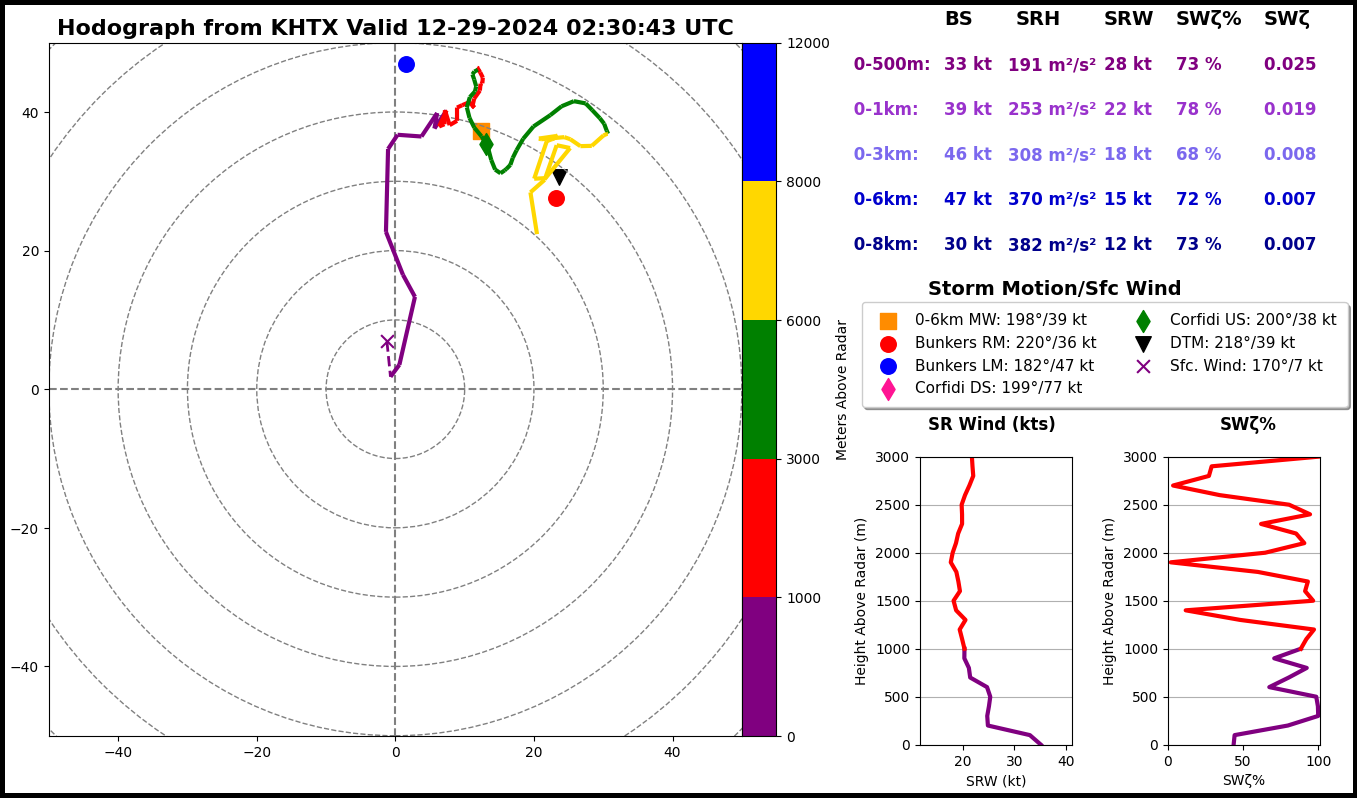

In [ ]:
# @title
def round_up_nearest(n):
    return 5 * math.ceil(n / 5)

#Create Figure
fig = plt.figure(figsize=(16,9), facecolor='white', edgecolor="black", linewidth = 6)
ax=fig.add_subplot(1,1,1)
if range_type == 'Dynamic':
  #Determine Component Ring For Dynamic
  magar = []
  magar.append(speed.max())
  magar.append(mean_mag)
  magar.append(rmag)
  magar.append(lmag)
  magar.append(cor_d_mag)
  magar.append(cor_u_mag)
  magar.append(dtm_mag)
  max2 = max(magar)
  hodo_rang = round_up_nearest(max2+10)
  h = Hodograph(ax, component_range = hodo_rang)
if range_type == 'Static':
  h = Hodograph(ax, component_range = static_value)
h.add_grid(increment = 10)

#Create Colormap
boundaries = np.array([0,1000,3000,6000,8000,12000])
colors = ['purple', 'red', 'green', 'gold', 'blue']

#Plot Hodograph and Winds
l = h.plot_colormapped(u_avg, v_avg, zlevels, intervals = boundaries, colors = colors)
try:
  mw = ax.scatter(u_mean, v_mean, color = 'darkorange', marker = 's', label = f"0-6km MW: {'{:.0f}'.format(mean_dirmet)}°/{'{:.0f} kt'.format(mean_mag)}", s = 125)
except:
  mw = ax.scatter(u_mean, v_mean, color = 'darkorange', marker = 's', label = f"0-6km MW: {mean_dirmet}°/{mean_mag} kt", s = 125)
try:
  rm = ax.scatter(rmu, rmv, color = 'red', marker = 'o', label = f"Bunkers RM: {'{:.0f}'.format(rang)}°/{'{:.0f} kt'.format(rmag)}", s = 125)
except:
  rm = ax.scatter(rmu, rmv, color = 'red', marker = 'o', label = f"Bunkers RM: {rang}°/{rmag} kt", s = 125)
try:
  lm = ax.scatter(lmu, lmv, color = 'blue', marker = 'o', label = f"Bunkers LM: {'{:.0f}'.format(lang)}°/{'{:.0f} kt'.format(lmag)}", s = 125)
except:
  lm = ax.scatter(lmu, lmv, color = 'blue', marker = 'o', label = f"Bunkers LM: {f'{lang}'}°/{f'{lmag} kt'}", s = 125)
try:
  cd = ax.scatter(cvd_u, cvd_v, color = 'deeppink', marker = 'd', s = 125, label = f"Corfidi DS: {'{:.0f}'.format(down_adj)}°/{'{:.0f} kt'.format(cor_d_mag)}")
except:
  cd = ax.scatter(cvd_u, cvd_v, color = 'deeppink', marker = 'd', s = 125, label = f"Corfidi DS: {f'{down_adj}°/{cor_d_mag} kt'}")
try:
  cu = ax.scatter(cvu_u, cvu_v, color = 'green', marker = 'd', s = 125, label = f"Corfidi US: {'{:.0f}'.format(up_adj)}°/{'{:.0f} kt'.format(cor_u_mag)}")
except:
  cu = ax.scatter(cvu_u, cvu_v, color = 'green', marker = 'd', s = 125, label = f"Corfidi US: {f'{up_adj}°/{cor_u_mag} kt'}")
try:
  dtm = ax.scatter(dtm_u, dtm_v, color = 'black', marker = 'v', s = 125, label = f"DTM: {'{:.0f}'.format(dtm_dir_cor)}°/{'{:.0f} kt'.format(dtm_mag)} ")
except:
  dtm = ax.scatter(dtm_u, dtm_v, color = 'black', marker = 'v', s = 125, label = f"DTM: {f'{dtm_dir_cor}°/{dtm_mag} kt'} ")

if storm_motion_method == 'User Selected':
    us = ax.scatter(u_sm, v_sm, color = 'black', marker = 'x', label = f"User SM: {'{:.0f}'.format(sm_dir)}/{'{:.0f}'.format(sm_speed)}", s = 125)
if sfc_status != 'None':
    sfc = ax.scatter(sfc_u, sfc_v, color = 'purple', marker = 'x', s = 85, label = f"Sfc. Wind: {'{:.0f}'.format(sfc_dir)}°/{'{:.0f} kt'.format(sfc_spd)}")
    plt.plot([sfc_u, u_avg[0]], [sfc_v, v_avg[0]], color="purple", linestyle = '--', linewidth = 2)

#Add Colorbar and Fig Text
CS = plt.colorbar(l, pad=0.00)
CS.set_label('Meters Above Radar')

plt.figtext(0.91, 0.9, "BS", fontsize = 14, weight = 'bold')
plt.figtext(0.955, 0.9, "SRH", fontsize = 14, weight = 'bold')
plt.figtext(1.01, 0.9, "SRW", fontsize = 14, weight = 'bold')
plt.figtext(1.055, 0.9, "SWζ%", fontsize = 14, weight = 'bold')
plt.figtext(1.11, 0.9, f"SWζ", fontsize = 14, weight = 'bold')

try:
  plt.figtext(0.85,0.85, f" 0-500m:", fontsize = 12, weight = 'bold', color = 'purple')
except:
  plt.figtext(0.85,0.85, f" 0-500m:", fontsize = 12, weight = 'bold', color = 'purple')
try:
  plt.figtext(0.91,0.85, f"{'{:.0f}'.format(shr005)} kt", fontsize = 12, weight = 'bold', color = 'purple')
except:
    plt.figtext(0.91,0.85, f"{shr005} kt", fontsize = 12, weight = 'bold', color = 'purple')
try:
  plt.figtext(0.95,0.85, f"{'{:.0f}'.format(SRH05) * SRH_units:~P}", fontsize = 12, weight = 'bold', color = 'purple')
except:
  plt.figtext(0.95,0.85, f"{SRH05 * SRH_units:~P}", fontsize = 12, weight = 'bold', color = 'purple')
try:
  plt.figtext(1.01,0.85, f"{'{:.0f}'.format(SR05) } kt", fontsize = 12, weight = 'bold', color = 'purple')
except:
  plt.figtext(1.01,0.85, f"{SR05} kt", fontsize = 12, weight = 'bold', color = 'purple')
try:
  plt.figtext(1.055,0.85, f"{'{:.0f}'.format(swper05) } %", fontsize = 12, weight = 'bold', color = 'purple')
except:
  plt.figtext(1.055,0.85, f"{swper05} %", fontsize = 12, weight = 'bold', color = 'purple')
try:
  plt.figtext(1.11,0.85, f"{'{:.3f}'.format(swvort05)} ", fontsize = 12, weight = 'bold', color = 'purple')
except:
  plt.figtext(1.11,0.85, f"{swvort05} ", fontsize = 12, weight = 'bold', color = 'purple')

try:
  plt.figtext(0.85,0.80, f" 0-1km: ", fontsize = 12, weight = 'bold', color = 'darkorchid')
except:
  plt.figtext(0.85,0.80, f" 0-1km: ", fontsize = 12, weight = 'bold', color = 'darkorchid')
try:
    plt.figtext(0.91,0.80, f"{'{:.0f}'.format(shr01)} kt", fontsize = 12, weight = 'bold', color = 'darkorchid')
except:
  plt.figtext(0.91,0.80, f"{shr01} kt", fontsize = 12, weight = 'bold', color = 'darkorchid')
try:
  plt.figtext(0.95,0.80, f"{'{:.0f}'.format(SRH1) * SRH_units:~P}", fontsize = 12, weight = 'bold', color = 'darkorchid')
except:
  plt.figtext(0.95,0.80, f"{SRH1 * SRH_units:~P}", fontsize = 12, weight = 'bold', color = 'darkorchid')
try:
  plt.figtext(1.01,0.80, f"{'{:.0f}'.format(SR1) } kt", fontsize = 12, weight = 'bold', color = 'darkorchid')
except:
  plt.figtext(1.01,0.80, f"{SR1} kt", fontsize = 12, weight = 'bold', color = 'darkorchid')
try:
  plt.figtext(1.055,0.80, f"{'{:.0f}'.format(swper1) } %", fontsize = 12, weight = 'bold', color = 'darkorchid')
except:
  plt.figtext(1.055,0.80, f"{swper1} %", fontsize = 12, weight = 'bold', color = 'darkorchid')
try:
  plt.figtext(1.11,0.80, f"{'{:.3f}'.format(swvort1)} ", fontsize = 12, weight = 'bold', color = 'darkorchid')
except:
  plt.figtext(1.11,0.80, f"{swvort1} ", fontsize = 12, weight = 'bold', color = 'darkorchid')

try:
  plt.figtext(0.85,0.75, f" 0-3km: ", fontsize = 12, weight = 'bold', color = 'mediumslateblue')
except:
  plt.figtext(0.85,0.75, f" 0-3km: ", fontsize = 12, weight = 'bold', color = 'mediumslateblue')
try:
  plt.figtext(0.91,0.75, f"{'{:.0f}'.format(shr03)} kt", fontsize = 12, weight = 'bold', color = 'mediumslateblue')
except:
  plt.figtext(0.91,0.75, f"{shr03} kt", fontsize = 12, weight = 'bold', color = 'mediumslateblue')
try:
  plt.figtext(0.95,0.75, f"{'{:.0f}'.format(SRH3) * SRH_units:~P}", fontsize = 12, weight = 'bold', color = 'mediumslateblue')
except:
  plt.figtext(0.95,0.75, f"{SRH3 * SRH_units:~P}", fontsize = 12, weight = 'bold', color = 'mediumslateblue')
try:
  plt.figtext(1.01,0.75, f"{'{:.0f}'.format(SR3) } kt", fontsize = 12, weight = 'bold', color = 'mediumslateblue')
except:
  plt.figtext(1.01,0.75, f"{SR3} kt", fontsize = 12, weight = 'bold', color = 'mediumslateblue')
try:
  plt.figtext(1.055,0.75, f"{'{:.0f}'.format(swper3) } %", fontsize = 12, weight = 'bold', color = 'mediumslateblue')
except:
  plt.figtext(1.055,0.75, f"{swper3} %", fontsize = 12, weight = 'bold', color = 'mediumslateblue')
try:
  plt.figtext(1.11,0.75, f"{'{:.3f}'.format(swvort3)} ", fontsize = 12, weight = 'bold', color = 'mediumslateblue')
except:
  plt.figtext(1.11,0.75, f"{swvort3} ", fontsize = 12, weight = 'bold', color = 'mediumslateblue')

try:
  plt.figtext(0.85,0.70, f" 0-6km: ", fontsize = 12, weight = 'bold', color = 'mediumblue')
except:
  plt.figtext(0.85,0.70, f" 0-6km: ", fontsize = 12, weight = 'bold', color = 'mediumblue')
try:
  plt.figtext(0.91,0.70, f"{'{:.0f}'.format(shr06)} kt", fontsize = 12, weight = 'bold', color = 'mediumblue')
except:
  plt.figtext(0.91,0.70, f"{shr06} kt", fontsize = 12, weight = 'bold', color = 'mediumblue')
try:
  plt.figtext(0.95,0.70, f"{'{:.0f}'.format(SRH6) * SRH_units:~P}", fontsize = 12, weight = 'bold', color = 'mediumblue')
except:
  plt.figtext(0.95,0.70, f"{SRH6 * SRH_units:~P}", fontsize = 12, weight = 'bold', color = 'mediumblue')
try:
  plt.figtext(1.01,0.70, f"{'{:.0f}'.format(SR6) } kt", fontsize = 12, weight = 'bold', color = 'mediumblue')
except:
  plt.figtext(1.01,0.70, f"{SR6} kt", fontsize = 12, weight = 'bold', color = 'mediumblue')
try:
  plt.figtext(1.055,0.70, f"{'{:.0f}'.format(swper6) } %", fontsize = 12, weight = 'bold', color = 'mediumblue')
except:
  plt.figtext(1.055,0.70, f"{swper6} %", fontsize = 12, weight = 'bold', color = 'mediumblue')
try:
  plt.figtext(1.11,0.70, f"{'{:.3f}'.format(swvort6)} ", fontsize = 12, weight = 'bold', color = 'mediumblue')
except:
  plt.figtext(1.11,0.70, f"{swvort6} ", fontsize = 12, weight = 'bold', color = 'mediumblue')

try:
  plt.figtext(0.85,0.65, f" 0-8km: ", fontsize = 12, weight = 'bold', color = 'darkblue')
except:
  plt.figtext(0.85,0.65, f" 0-8km: ", fontsize = 12, weight = 'bold', color = 'darkblue')
try:
  plt.figtext(0.91,0.65, f"{'{:.0f}'.format(shr08)} kt", fontsize = 12, weight = 'bold', color = 'darkblue')
except:
  plt.figtext(0.91,0.65, f"{shr08} kt", fontsize = 12, weight = 'bold', color = 'darkblue')
try:
  plt.figtext(0.95,0.65, f"{'{:.0f}'.format(SRH8) * SRH_units:~P}", fontsize = 12, weight = 'bold', color = 'darkblue')
except:
  plt.figtext(0.95,0.65, f"{SRH8 * SRH_units:~P}", fontsize = 12, weight = 'bold', color = 'darkblue')
try:
  plt.figtext(1.01,0.65, f"{'{:.0f}'.format(SR8) } kt", fontsize = 12, weight = 'bold', color = 'darkblue')
except:
  plt.figtext(1.01,0.65, f"{SR8} kt", fontsize = 12, weight = 'bold', color = 'darkblue')
try:
  plt.figtext(1.055,0.65, f"{'{:.0f}'.format(swper8) } %", fontsize = 12, weight = 'bold', color = 'darkblue')
except:
  plt.figtext(1.055,0.65, f"{swper8} %", fontsize = 12, weight = 'bold', color = 'darkblue')
try:
  plt.figtext(1.11,0.65, f"{'{:.3f}'.format(swvort8)} ", fontsize = 12, weight = 'bold', color = 'darkblue')
except:
  plt.figtext(1.11,0.65, f"{swvort8} ", fontsize = 12, weight = 'bold', color = 'darkblue')

plt.figtext(0.90,0.60, "Storm Motion/Sfc Wind", fontsize = 14, weight = 'bold')

plt.legend(loc = 'right', bbox_to_anchor=(1.885, 0.55),
          ncol=2, fancybox=True, shadow=True, fontsize=11, facecolor='white', framealpha=1.0,
            labelcolor='k', borderpad=0.7)
plt.title(f'Hodograph from {radar_id} Valid {datearr[2]}-{datearr[3]}-{datearr[0]}{datearr[1]} {out[0]}:{out[1]}:{out[2]} UTC', fontsize = 16, weight = 'bold')

try:
  #Plot SRW wrt Hgt
  sr_plot = plt.axes((0.895, 0.10, 0.095, 0.32))
  plt.figtext(0.94, 0.45, f'SR Wind (kts)', weight='bold', color='black', fontsize=12, ha='center')
  sr_plot.set_ylim(0,3000)
  sr_plot.set_xlim(sr_spd[0:31].min() -6,sr_spd[0:31].max() +6)
  sr_plot.plot(sr_spd[0:11], zlevels[0:11], color = 'purple', linewidth = 3)
  sr_plot.plot(sr_spd[10:31], zlevels[10:31], color = 'red', linewidth = 3)
  plt.ylabel('Height Above Radar (m)')
  plt.xlabel('SRW (kt)')
  plt.grid(axis='y')
except:
  pass

try:
  #Plot SW Vort Perc wrt Hgt
  swv_plot = plt.axes((1.05, 0.10, 0.095, 0.32))
  plt.figtext(1.1, 0.45, f'SWζ%', weight='bold', color='black', fontsize=12, ha='center')
  swv_plot.set_ylim(0,3000)
  swv_plot.set_xlim(00,101)
  swv_plot.plot(swvper[0:11], zlevels[0:11], color = 'purple', linewidth = 3)
  swv_plot.plot(swvper[10:31], zlevels[10:31], color = 'red', linewidth = 3)
  plt.ylabel('Height Above Radar (m)')
  plt.xlabel('SWζ%')
  plt.grid(axis='y')
except:
  pass
#Add Title and Legend and Save Figure

plt.savefig(f'/content/hodos/Hodograph_{radar_id}_{date}_{time}.png', bbox_inches='tight')

#Plot Storm Relative Hodograph

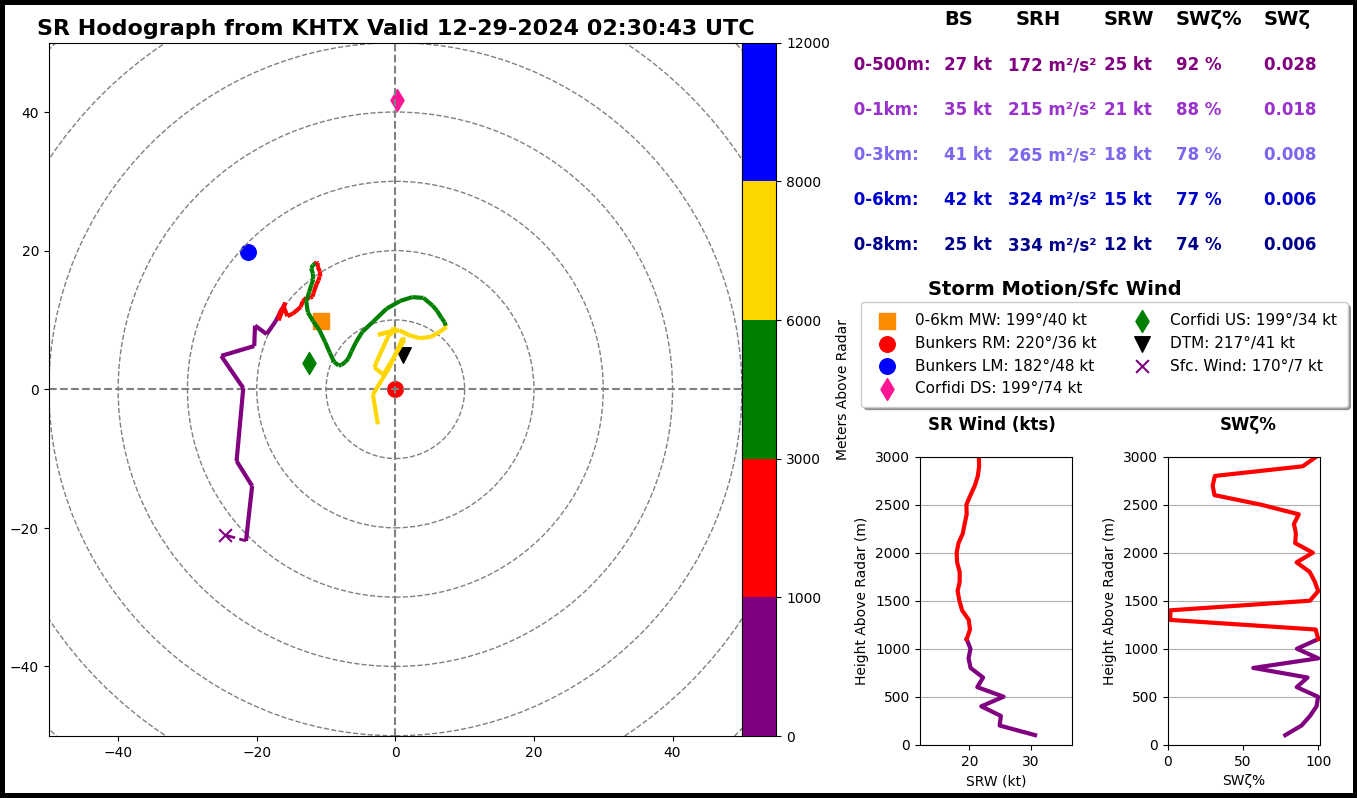

In [ ]:
# @title
def round_up_nearest(n):
    return 5 * math.ceil(n / 5)

#Create Figure
fig = plt.figure(figsize=(16,9), facecolor='white', edgecolor="black", linewidth = 6)
ax=fig.add_subplot(1,1,1)
if range_type == 'Dynamic':
  #Determine Component Ring For Dynamic
  magar = []
  magar.append(speed.max())
  magar.append(mean_mag)
  magar.append(rmag)
  magar.append(lmag)
  magar.append(cor_d_mag)
  magar.append(cor_u_mag)
  magar.append(dtm_mag)
  max2 = max(magar)
  hodo_rang = round_up_nearest(max2+10)
  h = Hodograph(ax, component_range = hodo_rang)
if range_type == 'Static':
  h = Hodograph(ax, component_range = static_value)
h.add_grid(increment = 10)

#Create Colormap
boundaries = np.array([0,1000,3000,6000,8000,12000])
colors = ['purple', 'red', 'green', 'gold', 'blue']

#Plot Hodograph and Winds
l = h.plot_colormapped(sr_u, sr_v, zlevels, intervals = boundaries, colors = colors)
try:
  mw = ax.scatter(sr_mw_u, sr_mw_v, color = 'darkorange', marker = 's', label = f"0-6km MW: {'{:.0f}'.format(mean_dirmet)}°/{'{:.0f} kt'.format(mean_mag)}", s = 125)
except:
  mw = ax.scatter(sr_mw_u, sr_mw_v, color = 'darkorange', marker = 's', label = f"0-6km MW: {mean_dirmet}°/{mean_mag} kt", s = 125)
try:
  rm = ax.scatter(sr_br_u, sr_br_v, color = 'red', marker = 'o', label = f"Bunkers RM: {'{:.0f}'.format(rang)}°/{'{:.0f} kt'.format(rmag)}", s = 125)
except:
  rm = ax.scatter(sr_br_u, sr_br_v, color = 'red', marker = 'o', label = f"Bunkers RM: {rang}°/{rmag} kt", s = 125)
try:
  lm = ax.scatter(sr_bl_u, sr_bl_v, color = 'blue', marker = 'o', label = f"Bunkers LM: {'{:.0f}'.format(lang)}°/{'{:.0f} kt'.format(lmag)}", s = 125)
except:
  lm = ax.scatter(sr_bl_u, sr_bl_v, color = 'blue', marker = 'o', label = f"Bunkers LM: {f'{lang}'}°/{f'{lmag} kt'}", s = 125)
try:
  cd = ax.scatter(sr_cd_u, sr_cd_v, color = 'deeppink', marker = 'd', s = 125, label = f"Corfidi DS: {'{:.0f}'.format(down_adj)}°/{'{:.0f} kt'.format(cor_d_mag)}")
except:
  cd = ax.scatter(sr_cd_u, sr_cd_v, color = 'deeppink', marker = 'd', s = 125, label = f"Corfidi DS: {f'{down_adj}°/{cor_d_mag} kt'}")
try:
  cu = ax.scatter(sr_cu_u, sr_cu_v, color = 'green', marker = 'd', s = 125, label = f"Corfidi US: {'{:.0f}'.format(up_adj)}°/{'{:.0f} kt'.format(cor_u_mag)}")
except:
  cu = ax.scatter(sr_cu_u, sr_cu_v, color = 'green', marker = 'd', s = 125, label = f"Corfidi US: {f'{up_adj}°/{cor_u_mag} kt'}")
try:
  dtm = ax.scatter(sr_dtm_u, sr_dtm_v, color = 'black', marker = 'v', s = 125, label = f"DTM: {'{:.0f}'.format(dtm_dir_cor)}°/{'{:.0f} kt'.format(dtm_mag)} ")
except:
  dtm = ax.scatter(sr_dtm_u, sr_dtm_v, color = 'black', marker = 'v', s = 125, label = f"DTM: {f'{dtm_dir_cor}°/{dtm_mag} kt'} ")

if storm_motion_method == 'User Selected':
  us = ax.scatter(sr_sm_u, sr_sm_v, color = 'black', marker = 'x', label = f"User SM: {'{:.0f}'.format(sm_dir)}/{'{:.0f}'.format(sm_speed)}", s = 125)
if sfc_status != 'None':
  sfc = ax.scatter(sr_sfc_u, sr_sfc_v, color = 'purple', marker = 'x', s = 85, label = f"Sfc. Wind: {'{:.0f}'.format(sfc_dir)}°/{'{:.0f} kt'.format(sfc_spd)}")
  plt.plot([sr_sfc_u, sr_u[0]], [sr_sfc_v, sr_v[0]], color="purple", linestyle = '--', linewidth = 2)

#Add Colorbar and Fig Text
CS = plt.colorbar(l, pad=0.00)
CS.set_label('Meters Above Radar')

plt.figtext(0.91, 0.9, "BS", fontsize = 14, weight = 'bold')
plt.figtext(0.955, 0.9, "SRH", fontsize = 14, weight = 'bold')
plt.figtext(1.01, 0.9, "SRW", fontsize = 14, weight = 'bold')
plt.figtext(1.055, 0.9, "SWζ%", fontsize = 14, weight = 'bold')
plt.figtext(1.11, 0.9, f"SWζ", fontsize = 14, weight = 'bold')

try:
  plt.figtext(0.85,0.85, f" 0-500m:", fontsize = 12, weight = 'bold', color = 'purple')
except:
  plt.figtext(0.85,0.85, f" 0-500m:", fontsize = 12, weight = 'bold', color = 'purple')
try:
  plt.figtext(0.91,0.85, f"{'{:.0f}'.format(shr005)} kt", fontsize = 12, weight = 'bold', color = 'purple')
except:
    plt.figtext(0.91,0.85, f"{shr005} kt", fontsize = 12, weight = 'bold', color = 'purple')
try:
  plt.figtext(0.95,0.85, f"{'{:.0f}'.format(SRH05) * SRH_units:~P}", fontsize = 12, weight = 'bold', color = 'purple')
except:
  plt.figtext(0.95,0.85, f"{SRH05 * SRH_units:~P}", fontsize = 12, weight = 'bold', color = 'purple')
try:
  plt.figtext(1.01,0.85, f"{'{:.0f}'.format(SR05) } kt", fontsize = 12, weight = 'bold', color = 'purple')
except:
  plt.figtext(1.01,0.85, f"{SR05} kt", fontsize = 12, weight = 'bold', color = 'purple')
try:
  plt.figtext(1.055,0.85, f"{'{:.0f}'.format(swper05) } %", fontsize = 12, weight = 'bold', color = 'purple')
except:
  plt.figtext(1.055,0.85, f"{swper05} %", fontsize = 12, weight = 'bold', color = 'purple')
try:
  plt.figtext(1.11,0.85, f"{'{:.3f}'.format(swvort05)} ", fontsize = 12, weight = 'bold', color = 'purple')
except:
  plt.figtext(1.11,0.85, f"{swvort05} ", fontsize = 12, weight = 'bold', color = 'purple')

try:
  plt.figtext(0.85,0.80, f" 0-1km: ", fontsize = 12, weight = 'bold', color = 'darkorchid')
except:
  plt.figtext(0.85,0.80, f" 0-1km: ", fontsize = 12, weight = 'bold', color = 'darkorchid')
try:
    plt.figtext(0.91,0.80, f"{'{:.0f}'.format(shr01)} kt", fontsize = 12, weight = 'bold', color = 'darkorchid')
except:
  plt.figtext(0.91,0.80, f"{shr01} kt", fontsize = 12, weight = 'bold', color = 'darkorchid')
try:
  plt.figtext(0.95,0.80, f"{'{:.0f}'.format(SRH1) * SRH_units:~P}", fontsize = 12, weight = 'bold', color = 'darkorchid')
except:
  plt.figtext(0.95,0.80, f"{SRH1 * SRH_units:~P}", fontsize = 12, weight = 'bold', color = 'darkorchid')
try:
  plt.figtext(1.01,0.80, f"{'{:.0f}'.format(SR1) } kt", fontsize = 12, weight = 'bold', color = 'darkorchid')
except:
  plt.figtext(1.01,0.80, f"{SR1} kt", fontsize = 12, weight = 'bold', color = 'darkorchid')
try:
  plt.figtext(1.055,0.80, f"{'{:.0f}'.format(swper1) } %", fontsize = 12, weight = 'bold', color = 'darkorchid')
except:
  plt.figtext(1.055,0.80, f"{swper1} %", fontsize = 12, weight = 'bold', color = 'darkorchid')
try:
  plt.figtext(1.11,0.80, f"{'{:.3f}'.format(swvort1)} ", fontsize = 12, weight = 'bold', color = 'darkorchid')
except:
  plt.figtext(1.11,0.80, f"{swvort1} ", fontsize = 12, weight = 'bold', color = 'darkorchid')

try:
  plt.figtext(0.85,0.75, f" 0-3km: ", fontsize = 12, weight = 'bold', color = 'mediumslateblue')
except:
  plt.figtext(0.85,0.75, f" 0-3km: ", fontsize = 12, weight = 'bold', color = 'mediumslateblue')
try:
  plt.figtext(0.91,0.75, f"{'{:.0f}'.format(shr03)} kt", fontsize = 12, weight = 'bold', color = 'mediumslateblue')
except:
  plt.figtext(0.91,0.75, f"{shr03} kt", fontsize = 12, weight = 'bold', color = 'mediumslateblue')
try:
  plt.figtext(0.95,0.75, f"{'{:.0f}'.format(SRH3) * SRH_units:~P}", fontsize = 12, weight = 'bold', color = 'mediumslateblue')
except:
  plt.figtext(0.95,0.75, f"{SRH3 * SRH_units:~P}", fontsize = 12, weight = 'bold', color = 'mediumslateblue')
try:
  plt.figtext(1.01,0.75, f"{'{:.0f}'.format(SR3) } kt", fontsize = 12, weight = 'bold', color = 'mediumslateblue')
except:
  plt.figtext(1.01,0.75, f"{SR3} kt", fontsize = 12, weight = 'bold', color = 'mediumslateblue')
try:
  plt.figtext(1.055,0.75, f"{'{:.0f}'.format(swper3) } %", fontsize = 12, weight = 'bold', color = 'mediumslateblue')
except:
  plt.figtext(1.055,0.75, f"{swper3} %", fontsize = 12, weight = 'bold', color = 'mediumslateblue')
try:
  plt.figtext(1.11,0.75, f"{'{:.3f}'.format(swvort3)} ", fontsize = 12, weight = 'bold', color = 'mediumslateblue')
except:
  plt.figtext(1.11,0.75, f"{swvort3} ", fontsize = 12, weight = 'bold', color = 'mediumslateblue')

try:
  plt.figtext(0.85,0.70, f" 0-6km: ", fontsize = 12, weight = 'bold', color = 'mediumblue')
except:
  plt.figtext(0.85,0.70, f" 0-6km: ", fontsize = 12, weight = 'bold', color = 'mediumblue')
try:
  plt.figtext(0.91,0.70, f"{'{:.0f}'.format(shr06)} kt", fontsize = 12, weight = 'bold', color = 'mediumblue')
except:
  plt.figtext(0.91,0.70, f"{shr06} kt", fontsize = 12, weight = 'bold', color = 'mediumblue')
try:
  plt.figtext(0.95,0.70, f"{'{:.0f}'.format(SRH6) * SRH_units:~P}", fontsize = 12, weight = 'bold', color = 'mediumblue')
except:
  plt.figtext(0.95,0.70, f"{SRH6 * SRH_units:~P}", fontsize = 12, weight = 'bold', color = 'mediumblue')
try:
  plt.figtext(1.01,0.70, f"{'{:.0f}'.format(SR6) } kt", fontsize = 12, weight = 'bold', color = 'mediumblue')
except:
  plt.figtext(1.01,0.70, f"{SR6} kt", fontsize = 12, weight = 'bold', color = 'mediumblue')
try:
  plt.figtext(1.055,0.70, f"{'{:.0f}'.format(swper6) } %", fontsize = 12, weight = 'bold', color = 'mediumblue')
except:
  plt.figtext(1.055,0.70, f"{swper6} %", fontsize = 12, weight = 'bold', color = 'mediumblue')
try:
  plt.figtext(1.11,0.70, f"{'{:.3f}'.format(swvort6)} ", fontsize = 12, weight = 'bold', color = 'mediumblue')
except:
  plt.figtext(1.11,0.70, f"{swvort6} ", fontsize = 12, weight = 'bold', color = 'mediumblue')

try:
  plt.figtext(0.85,0.65, f" 0-8km: ", fontsize = 12, weight = 'bold', color = 'darkblue')
except:
  plt.figtext(0.85,0.65, f" 0-8km: ", fontsize = 12, weight = 'bold', color = 'darkblue')
try:
  plt.figtext(0.91,0.65, f"{'{:.0f}'.format(shr08)} kt", fontsize = 12, weight = 'bold', color = 'darkblue')
except:
  plt.figtext(0.91,0.65, f"{shr08} kt", fontsize = 12, weight = 'bold', color = 'darkblue')
try:
  plt.figtext(0.95,0.65, f"{'{:.0f}'.format(SRH8) * SRH_units:~P}", fontsize = 12, weight = 'bold', color = 'darkblue')
except:
  plt.figtext(0.95,0.65, f"{SRH8 * SRH_units:~P}", fontsize = 12, weight = 'bold', color = 'darkblue')
try:
  plt.figtext(1.01,0.65, f"{'{:.0f}'.format(SR8) } kt", fontsize = 12, weight = 'bold', color = 'darkblue')
except:
  plt.figtext(1.01,0.65, f"{SR8} kt", fontsize = 12, weight = 'bold', color = 'darkblue')
try:
  plt.figtext(1.055,0.65, f"{'{:.0f}'.format(swper8) } %", fontsize = 12, weight = 'bold', color = 'darkblue')
except:
  plt.figtext(1.055,0.65, f"{swper8} %", fontsize = 12, weight = 'bold', color = 'darkblue')
try:
  plt.figtext(1.11,0.65, f"{'{:.3f}'.format(swvort8)} ", fontsize = 12, weight = 'bold', color = 'darkblue')
except:
  plt.figtext(1.11,0.65, f"{swvort8} ", fontsize = 12, weight = 'bold', color = 'darkblue')

plt.figtext(0.90,0.60, "Storm Motion/Sfc Wind", fontsize = 14, weight = 'bold')

plt.legend(loc = 'right', bbox_to_anchor=(1.885, 0.55),
          ncol=2, fancybox=True, shadow=True, fontsize=11, facecolor='white', framealpha=1.0,
            labelcolor='k', borderpad=0.7)
plt.title(f'SR Hodograph from {radar_id} Valid {datearr[2]}-{datearr[3]}-{datearr[0]}{datearr[1]} {out[0]}:{out[1]}:{out[2]} UTC', fontsize = 16, weight = 'bold')

try:
#Plot SRW wrt Hgt
  sr_plot = plt.axes((0.895, 0.10, 0.095, 0.32))
  plt.figtext(0.94, 0.45, f'SR Wind (kts)', weight='bold', color='black', fontsize=12, ha='center')
  sr_plot.set_ylim(0,3000)
  sr_plot.set_xlim(sr_spd[0:31].min() -6,sr_spd[0:31].max() +6)
  sr_plot.plot(sr_spd[0:11], zlevels[0:11], color = 'purple', linewidth = 3)
  sr_plot.plot(sr_spd[10:31], zlevels[10:31], color = 'red', linewidth = 3)
  plt.ylabel('Height Above Radar (m)')
  plt.xlabel('SRW (kt)')
  plt.grid(axis='y')
except:
  pass

try:
  #Plot SW Vort Perc wrt Hgt
  swv_plot = plt.axes((1.05, 0.10, 0.095, 0.32))
  plt.figtext(1.1, 0.45, f'SWζ%', weight='bold', color='black', fontsize=12, ha='center')
  swv_plot.set_ylim(0,3000)
  swv_plot.set_xlim(00,101)
  swv_plot.plot(swvper[0:11], zlevels[0:11], color = 'purple', linewidth = 3)
  swv_plot.plot(swvper[10:31], zlevels[10:31], color = 'red', linewidth = 3)
  plt.ylabel('Height Above Radar (m)')
  plt.xlabel('SWζ%')
  plt.grid(axis='y')
except:
  pass
#Add Title and Legend and Save Figure

plt.savefig(f'/content/sr_hodos/SR_Hodograph_{radar_id}_{date}_{time}.png', bbox_inches='tight')